In [1]:
import pickle
import numpy as np

from mofnet import DataLoader, MOFNet

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import Problem
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.optimize import minimize
import pymoo.gradient.toolbox as anp

In [2]:
data_loader = DataLoader.from_state("data_loader_state-20200116.npz")

# This hash dicts map budilding block names to unique index.
topo_hash = data_loader.topo_hash
node_hash = data_loader.node_hash
edge_hash = data_loader.edge_hash

mofnet = MOFNet()
mofnet.initialize_weights()
training_name = "cycle_tot"
mofnet.load_weights("cycle_tot/mofnet-{n:}-min.h5".format(n=training_name))

In [3]:
mofnet_n2 = MOFNet()
mofnet_n2.initialize_weights()
training_name = "cycle_tot"
mofnet_n2.load_weights("cycle_tot_n2/mofnet-{n:}-min.h5".format(n=training_name))

In [4]:
def mofnet_prediction(x_test_name):
    test_bulk=data_loader.make_dataset(
        np.array(x_test_name, dtype=str),
        np.array([0.0]*len(x_test_name)),
        batch_size=10000,
        repeat=False,
        shuffle=False,
    )
    prediction=[]
    for x, y in test_bulk:
        prediction.append(mofnet(x)*50)
    return prediction[0]

In [5]:
def mofnet_n2_prediction(x_test_name):
    test_bulk=data_loader.make_dataset(
        np.array(x_test_name, dtype=str),
        np.array([0.0]*len(x_test_name)),
        batch_size=10000,
        repeat=False,
        shuffle=False,
    )
    prediction=[]
    for x, y in test_bulk:
        prediction.append(mofnet_n2(x))
    return prediction[0]

In [6]:
def get_mof_name(topo,avail_nbbs,n_ebbs,variables_list):
    name_list=[]
    for variables in variables_list:
        name=topo+'+N22'
        for i in range(len(avail_nbbs)):
            name=name+"+"+avail_nbbs[i][2][variables[i]]
        for j in range(len(avail_nbbs),len(avail_nbbs)+n_ebbs):
            name=name+"+"+avail_ebbs[2][variables[j]]
        name_list.append(name)
    return name_list

In [7]:
def get_mof_name_independent(topo,x):
        topo_cn=topo_cn_arr[topo_cn_arr[:,0]==topo][0] #connection profile of each bbs in the topo
        n_bbs=topo_cn[2][0]+topo_cn[2][1]-1 #unique nbb amounts in the topo
        n_ebbs=topo_cn[2][1] #unique ebb amounts in the topo
        avail_nbbs=[]
        xu_list=[]
        for nbb_cn in topo_cn[1][1:]:
            nbb=bb_cn_arr[bb_cn_arr[:,0]==nbb_cn][0]
            avail_nbbs.append(nbb)
        for avail_nbb in avail_nbbs:
            xu_list.append(avail_nbb[1]-1)
        for avail_ebb in range(n_ebbs):
            xu_list.append(avail_ebbs[1]-1)
        return get_mof_name(topo,avail_nbbs,n_ebbs,x)

In [8]:
#global variables
with open('topo_cn_arr.pickle', 'rb') as file:
    topo_cn_arr = pickle.load(file)
with open('bb_cn_arr.pickle', 'rb') as file:
    bb_cn_arr = pickle.load(file)
avail_ebbs=bb_cn_arr[bb_cn_arr[:,0]==2][0]
avail_topos=topo_cn_arr[:,0]
#np.savetxt("avail_topos.txt",avail_topos,fmt="%s")
topo_cn_arr,bb_cn_arr,avail_ebbs,avail_topos #[name,nbb_types,n_nbbs&ebbs],[cn,n_bbs,bbs_list]

(array([['abf', list([4, 3, 4]), list([3, 3])],
        ['abr', list([4, 4, 4]), list([3, 3])],
        ['acs', list([6]), list([1, 1])],
        ...,
        ['xbh', list([6, 4]), list([2, 2])],
        ['urp', list([8, 12, 3]), list([3, 2])],
        ['twf-e', list([6]), list([1, 1])]], dtype=object),
 array([[2, 220,
         list(['E0', 'E226', 'E50', 'E162', 'E139', 'E212', 'E51', 'E19', 'E27', 'E44', 'E182', 'E127', 'E102', 'E173', 'E63', 'E70', 'E158', 'E132', 'E108', 'E146', 'E69', 'E184', 'E138', 'E168', 'E115', 'E88', 'E79', 'E217', 'E128', 'E52', 'E58', 'E92', 'E48', 'E216', 'E67', 'E165', 'E204', 'E175', 'E202', 'E66', 'E131', 'E95', 'E71', 'E15', 'E37', 'E13', 'E166', 'E72', 'E18', 'E73', 'E167', 'E205', 'E228', 'E206', 'E186', 'E185', 'E220', 'E89', 'E149', 'E180', 'E76', 'E171', 'E151', 'E43', 'E84', 'E119', 'E25', 'E29', 'E14', 'E45', 'E16', 'E57', 'E199', 'E159', 'E85', 'E192', 'E120', 'E130', 'E195', 'E26', 'E201', 'E156', 'E143', 'E211', 'E197', 'E142', 'E160', 'E153

In [9]:
class carbon_problem(Problem):
    
    def __init__(self):  
        self.topo_name='dni-d'
        self.topo=self.topo_name 
        self.topo_cn=topo_cn_arr[topo_cn_arr[:,0]==self.topo][0] #connection profile of each bbs in the topo
        self.n_bbs=self.topo_cn[2][0]+self.topo_cn[2][1]-1 #unique bb amounts in the topo
        self.n_ebbs=self.topo_cn[2][1] #unique ebb amounts in the topo
        self.avail_nbbs=[]
        self.xu_list=[]
        for nbb_cn in self.topo_cn[1][1:]:
            nbb=bb_cn_arr[bb_cn_arr[:,0]==nbb_cn][0]
            self.avail_nbbs.append(nbb)
        for avail_nbb in self.avail_nbbs:
            self.xu_list.append(avail_nbb[1]-1)
        for avail_ebb in range(self.n_ebbs):
            self.xu_list.append(avail_ebbs[1]-1)
        super().__init__(n_var=self.n_bbs, n_obj=2, n_ieq_constr=0, vtype=int)
        self.xl = np.zeros(self.n_var).astype(int)
        self.xu = np.array(self.xu_list)
        print(self.topo_cn,self.xu)

    def _evaluate(self, x, out, *args, **kwargs):
        self.mof_name_list=get_mof_name(self.topo,self.avail_nbbs,self.n_ebbs,x)
        f1 = -mofnet_prediction(self.mof_name_list)[:,0]
        f2 = mofnet_n2_prediction(self.mof_name_list)[:,0]


        out["F"] = anp.column_stack([f1, f2])

    def _calc_pareto_front(self, n_points=100):
        initial_pop=[]
        for i in range(self.n_var):
            x0=np.linspace(0, self.xu[i], n_points, dtype=int)
            initial_pop.append(x0)
            
        X = np.column_stack(initial_pop)
        return self.evaluate(X, return_values_of=["F"])

In [10]:
algorithm = NSGA2(pop_size=100,
                      sampling=IntegerRandomSampling(),
                        crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
                        mutation=PM(prob=0.5, eta=3.0, vtype=float, repair=RoundingRepair()))

['dni-d' list([24, 3]) list([2, 2])] [ 77 219 219]
n_gen  |  n_eval  | n_nds  |      igd      |       gd      |       hv     
     1 |      100 |      6 |  0.2830358477 |  0.0630765328 |  0.3211942228
     2 |      200 |      8 |  0.3121118629 |  0.0963320540 |  0.5298289384
     3 |      300 |      9 |  0.4805194499 |  0.1948220095 |  0.8378607254
     4 |      400 |      8 |  0.5082224466 |  0.1931808487 |  1.1296909350
     5 |      500 |      8 |  0.5320344210 |  0.1961614281 |  1.2252752846
     6 |      600 |     11 |  0.5564104139 |  0.2277159084 |  1.2582934079
     7 |      700 |      9 |  0.5788578093 |  0.3148050972 |  1.4167869817
     8 |      800 |      7 |  0.5768384241 |  0.4035504544 |  1.4310471220
     9 |      900 |      8 |  0.5729037564 |  0.3903245133 |  1.4669567754
    10 |     1000 |      8 |  0.6648909116 |  0.4106531903 |  1.4792683559
    11 |     1100 |      9 |  0.6636781186 |  0.4243413917 |  1.4819548975
    12 |     1200 |     10 |  0.6806574102 |  0.4

   107 |    10700 |     23 |  0.7304594168 |  0.5195146834 |  1.6781115257
   108 |    10800 |     23 |  0.7304594168 |  0.5195146834 |  1.6781115257
   109 |    10900 |     23 |  0.7304594168 |  0.5195146834 |  1.6781115257
   110 |    11000 |     23 |  0.7304594168 |  0.5195146834 |  1.6781115257
   111 |    11100 |     23 |  0.7304594168 |  0.5195146834 |  1.6781115257
   112 |    11200 |     23 |  0.7304594168 |  0.5195146834 |  1.6781115257
   113 |    11300 |     23 |  0.7304594168 |  0.5195146834 |  1.6781115257
   114 |    11400 |     23 |  0.7304594168 |  0.5195146834 |  1.6781115257
   115 |    11500 |     23 |  0.7304594168 |  0.5195146834 |  1.6781115257
   116 |    11600 |     23 |  0.7304594168 |  0.5195146834 |  1.6781115257
   117 |    11700 |     23 |  0.7304594168 |  0.5195146834 |  1.6781115257
   118 |    11800 |     23 |  0.7304594168 |  0.5195146834 |  1.6781115257
   119 |    11900 |     23 |  0.7304594168 |  0.5195146834 |  1.6781115257
   120 |    12000 |     2

   217 |    21700 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   218 |    21800 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   219 |    21900 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   220 |    22000 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   221 |    22100 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   222 |    22200 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   223 |    22300 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   224 |    22400 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   225 |    22500 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   226 |    22600 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   227 |    22700 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   228 |    22800 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   229 |    22900 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   230 |    23000 |     2

   327 |    32700 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   328 |    32800 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   329 |    32900 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   330 |    33000 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   331 |    33100 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   332 |    33200 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   333 |    33300 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   334 |    33400 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   335 |    33500 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   336 |    33600 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   337 |    33700 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   338 |    33800 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   339 |    33900 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   340 |    34000 |     2

   437 |    43700 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   438 |    43800 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   439 |    43900 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   440 |    44000 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   441 |    44100 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   442 |    44200 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   443 |    44300 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   444 |    44400 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   445 |    44500 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   446 |    44600 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   447 |    44700 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   448 |    44800 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   449 |    44900 |     25 |  0.7141357099 |  0.5127095500 |  1.6794902979
   450 |    45000 |     2

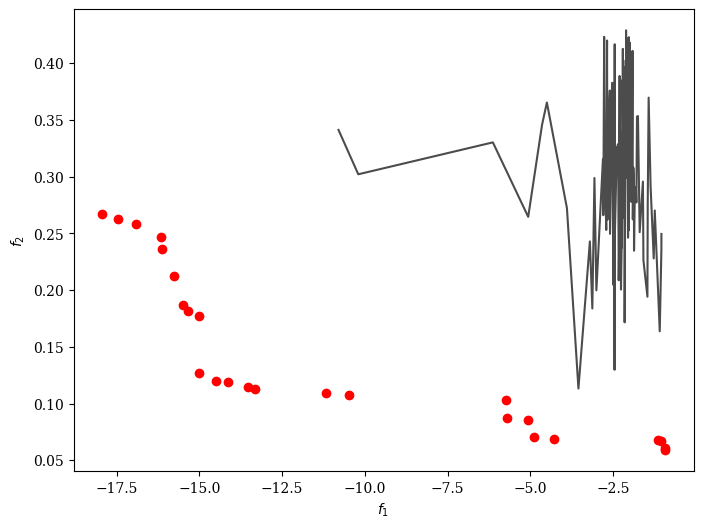

In [11]:
target_topo='dni-d'
problem = carbon_problem()
res = minimize(problem,
                   algorithm,
                   termination=('n_gen', 500),
                   seed=1,
                   save_history=True,verbose=True)
plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, color="red")
plot.show()
final_mofs=get_mof_name_independent(target_topo,res.X)
final_results=np.vstack((get_mof_name_independent(target_topo,res.X),res.F.T)).T #[name,q_co2,lg(q_n2)]
np.savetxt("nsga_result/"+target_topo+".txt",final_results,fmt="%s")

In [12]:
test=['abf+N342+N320+N562+E58+E180+E37']
-mofnet_prediction(['abf+N342+N320+N562+E58+E180+E37'])[:,0],np.log(mofnet_n2_prediction(['abf+N342+N320+N562+E58+E180+E37'])[:,0])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-7.107813], dtype=float32)>,
 array([-1.0908568], dtype=float32))

In [13]:
topo_cn_arr[topo_cn_arr[:,0]=='dni-d']

array([['dni-d', list([24, 3]), list([2, 2])]], dtype=object)